In [83]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:

DATA_PATH = "/kaggle/input/youtubecommentsdataset/YoutubeCommentsDataSet.csv"
df = pd.read_csv(DATA_PATH)

print(df.head())
print(df.info())
print(df['Sentiment'].value_counts())


                                             Comment Sentiment
0  lets not forget that apple pay in 2014 require...   neutral
1  here in nz 50 of retailers don’t even have con...  negative
2  i will forever acknowledge this channel with t...  positive
3  whenever i go to a place that doesn’t take app...  negative
4  apple pay is so convenient secure and easy to ...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB
None
Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))


keep_words = {
    "not", "no", "nor",
    "don't", "didn't", "doesn't",
    "isn't", "wasn't", "aren't", "weren't",
    "can't", "couldn't", "won't", "wouldn't",
    "shouldn't", "haven't", "hasn't", "hadn't"
}


stop_words = stop_words - keep_words


def clean_text(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\d+", " ", text)
    # tokenize
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)


df['clean_comment'] = df['Comment'].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 切 train/val/test

In [ ]:
TEXT_COL = "clean_comment"   
LABEL_COL = "Sentiment"

X = df[TEXT_COL]
y = df[LABEL_COL]

# label -> int
le = LabelEncoder()
y_int = le.fit_transform(y)

# 先切出 test = 10%（random_state=42 + stratify）
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_int,
    test_size=0.1,
    random_state=42,
    stratify=y_int
)

print("Total samples:", len(df))
print("Train+Val size:", len(X_train_val))
print("Test size:", len(X_test))

# 從 train_val 切 validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.1,
    random_state=42,
    stratify=y_train_val
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))

# test 前五筆
preview = pd.DataFrame({
    "text": X_test.head().values,
    "label_int": y_test[:5],
    "label": le.inverse_transform(y_test[:5])
})
print(preview)


Total samples: 18408
Train+Val size: 16567
Test size: 1841
Train size: 14910
Val size: 1657
                                                text  label_int     label
0               realises fifth question quiz started          1   neutral
1  directioners repeat not end not end make know ...          1   neutral
2  nature meateating plants nature years future p...          1   neutral
3  apple tv dijo este año voy con todo en lo pers...          1   neutral
4  daniel friend legend good see passion enthusia...          2  positive


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# y_train label (0/1/2)
classes = np.unique(y_train)

class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, class_weights_arr))
print("Class weights:", class_weights)


Class weights: {0: 2.6240760295670538, 1: 1.3232161874334398, 2: 0.5367170626349892}


# Tokenizer + padding

In [ ]:
max_words = 20000   
max_len   = 150     

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

def texts_to_padded(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')

X_train_pad = texts_to_padded(X_train)
X_val_pad   = texts_to_padded(X_val)
X_test_pad  = texts_to_padded(X_test)


# LSTM

In [90]:
embedding_dim = 256
lstm_units = 128
dense_units = 64
num_classes = len(le.classes_)

model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len),
    Bidirectional(LSTM(lstm_units)),      # 一層 BiLSTM 就好
    Dense(dense_units, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [91]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[es],
    class_weight=class_weights   # ★
)


Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4898 - loss: 1.0138 - val_accuracy: 0.6657 - val_loss: 0.7645
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7780 - loss: 0.5826 - val_accuracy: 0.7031 - val_loss: 0.7628
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8706 - loss: 0.3354 - val_accuracy: 0.7266 - val_loss: 0.8288
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9170 - loss: 0.2210 - val_accuracy: 0.7133 - val_loss: 1.0126
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9484 - loss: 0.1396 - val_accuracy: 0.7067 - val_loss: 1.0607


# test set 預測 + 存CSV

In [92]:
import numpy as np

# 機率 & 預測 label
y_test_proba = model.predict(X_test_pad)
y_test_pred  = np.argmax(y_test_proba, axis=1)

print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Test accuracy: 0.7050516023900054
              precision    recall  f1-score   support

    negative       0.44      0.72      0.55       234
     neutral       0.53      0.62      0.57       464
    positive       0.92      0.73      0.82      1143

    accuracy                           0.71      1841
   macro avg       0.63      0.69      0.65      1841
weighted avg       0.76      0.71      0.72      1841



In [93]:
true_labels = le.inverse_transform(y_test)
pred_labels = le.inverse_transform(y_test_pred)

pred_df = pd.DataFrame({
    "text": X_test.values,         
    "true_label": true_labels,
    "pred_label": pred_labels,
})

for idx, cls in enumerate(le.classes_):
    pred_df[f"prob_{cls}"] = y_test_proba[:, idx]

pred_df.head()


,text,true_label,pred_label,prob_negative,prob_neutral,prob_positive
0,realises fifth question quiz started,neutral,neutral,0.156500,0.796511,0.046988
1,directioners repeat not end not end make know ...,neutral,negative,0.894981,0.092461,0.012558
2,nature meateating plants nature years future p...,neutral,neutral,0.040102,0.798450,0.161448
3,apple tv dijo este año voy con todo en lo pers...,neutral,neutral,0.003045,0.943171,0.053784
4,daniel friend legend good see passion enthusia...,positive,positive,0.000183,0.006745,0.993072


In [94]:
OUTPUT_CSV = "lstm_predictions.csv"
pred_df.to_csv(OUTPUT_CSV, index=False)
print("Saved to", OUTPUT_CSV)


Saved to lstm_predictions.csv


In [95]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix
)

print("================ LSTM ================")

# 1. Accuracy + classification report
acc = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# 2. One-vs-Rest AUC（正 vs 其他、中 vs 其他、負 vs 其他）
print("\nOne-vs-Rest AUC:")
for idx, cls_name in enumerate(le.classes_):
    # 這類當成 1，其它類當成 0
    y_true_bin = (y_test == idx).astype(int)
    auc = roc_auc_score(y_true_bin, y_test_proba[:, idx])
    print(f"AUC for {cls_name} ({idx}): {auc:.4f}")

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (rows = true, cols = predicted):")
print(cm)


================ LSTM ================
Accuracy: 0.7051

Classification Report:
              precision    recall  f1-score   support

    negative       0.44      0.72      0.55       234
     neutral       0.53      0.62      0.57       464
    positive       0.92      0.73      0.82      1143

    accuracy                           0.71      1841
   macro avg       0.63      0.69      0.65      1841
weighted avg       0.76      0.71      0.72      1841


One-vs-Rest AUC:
AUC for negative (0): 0.8796
AUC for neutral (1): 0.8277
AUC for positive (2): 0.9047

Confusion Matrix (rows = true, cols = predicted):
[[169  49  16]
 [117 289  58]
 [ 97 206 840]]


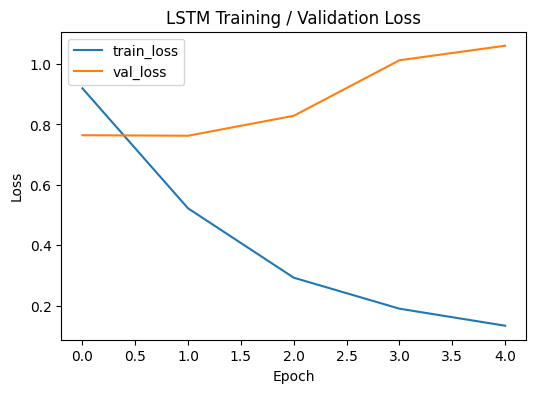

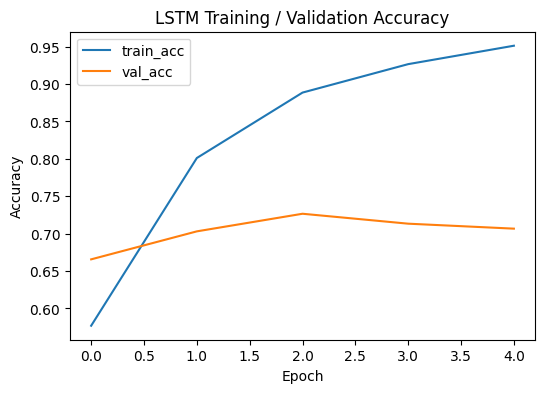

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training / Validation Loss')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Training / Validation Accuracy')
plt.show()


In [97]:
print("LSTM training configuration:")
print(f"- vocab size: {max_words}")
print(f"- max sequence length: {max_len}")
print(f"- embedding dim: {embedding_dim}")
print(f"- LSTM units: {hidden_size1} + {hidden_size2}")
print("- optimizer: Adam, batch size: 128, max epochs: 10, early stopping (patience=3)")


LSTM training configuration:
- vocab size: 20000
- max sequence length: 150
- embedding dim: 256
- LSTM units: 128 + 64
- optimizer: Adam, batch size: 128, max epochs: 10, early stopping (patience=3)
